# 🌊 Ocean & Wildlife AI Explorer - Multimodal AI Demo

## Overview  
This notebook demonstrates **multimodal AI capabilities** using Google's Gemini:

1. **Image Generation**: Create procedural ocean/coral reef scenes
2. **Vision AI**: Analyze images and extract insights
3. **Text Conversation**: Engage in AI discussions about science
4. **Creative Tasks**: Generate descriptions and artistic content

### References:
- [Gemini Multimodal Capabilities](https://developers.googleblog.com/en/7-examples-of-geminis-multimodal-capabilities-in-action/)
- [DataCamp Janus Pro Guide](https://www.datacamp.com/blog/janus-pro)
- [DeepSeek R1 Tutorial](https://www.datacamp.com/blog/deepseek-r1)

---

In [1]:
# Installation and imports
!pip install -q -U "google-genai" pillow matplotlib seaborn

from google import genai
from google.genai import types
from google.colab import userdata
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from io import BytesIO
import time
from IPython.display import display, Markdown, HTML
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'

print('═' * 80)
print('  🐠 OCEAN & WILDLIFE AI EXPLORER  ')
print('  Multimodal AI Demo with Gemini  ')
print('═' * 80)

# ── Free-tier strategy ──────────────────────────────────────────────────────
# • Use ONE model only (gemini-2.5-flash) — free, fast, multimodal
# • No client.models.list() call — saves RPM quota
# • Total notebook API calls: exactly 2 (vision + text)
# • 15 s cooldown between calls to stay under free-tier RPM
# ─────────────────────────────────────────────────────────────────────────────
MODEL = 'gemini-2.5-flash'          # Free tier, supports text + vision
REQUEST_COOLDOWN = 15               # Seconds between API requests

# Configure API (using Colab secrets)
try:
    GEMINI_KEY = userdata.get('GEMINI_API_KEY')
    client = genai.Client(api_key=GEMINI_KEY)
    print(f'\n✅ API configured — model: {MODEL}')
    print(f'   Rate-limit guard: {REQUEST_COOLDOWN}s cooldown between requests')
    API_READY = True
except Exception:
    print('\n⚠️  API key not found — some features will use mock data')
    print('   To enable: Add GEMINI_API_KEY in Colab Secrets')
    API_READY = False

print('\n' + '─' * 80)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.7/724.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 136.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.50.0 requires pillow<12.0,>=8.0, but you have pillow 12.1.1 which is incompatible.
════════════════════════════════════════════════════════════════════════════════
  🐠 OCEAN & WILDLIFE AI EXPLORER  
  Multimodal AI Demo with Gemini  
════════════════════════════════════════════════════════════════════════════════

✅ API configured — model: gemini-2.5-flash
   Rate-limit guard: 15s cooldown between requests

────────

## 📋 Helper Functions
Utility functions for API calls with error handling

In [2]:
# Track last request time to enforce cooldown
_last_request_time = 0

def smart_api_call(prompt_data, task_name="API Call"):
    """
    Single-model API caller with free-tier-safe rate limiting.

    • Uses only the MODEL defined in setup (gemini-2.5-flash)
    • Enforces REQUEST_COOLDOWN between calls to avoid 429
    • One attempt + one automatic retry on transient errors

    Args:
        prompt_data: String or list containing prompt/images
        task_name: Description of the task

    Returns:
        Response object or None
    """
    global _last_request_time

    if not API_READY:
        print(f'  ⏭️  {task_name}: API unavailable, using fallback')
        return None

    # ── Enforce cooldown ─────────────────────────────────────────────────
    elapsed = time.time() - _last_request_time
    if elapsed < REQUEST_COOLDOWN:
        wait = REQUEST_COOLDOWN - elapsed
        print(f'  ⏳ Cooling down {wait:.0f}s to respect free-tier RPM limit...')
        time.sleep(wait)

    # ── Single attempt (+ 1 retry on 429) ────────────────────────────────
    for attempt in range(2):
        try:
            print(f'  🔄 {task_name} [{MODEL}]', end=' ... ')
            _last_request_time = time.time()

            result = client.models.generate_content(
                model=MODEL,
                contents=prompt_data,
                config=types.GenerateContentConfig(
                    temperature=0.7,
                )
            )

            if result and hasattr(result, 'text') and result.text:
                print('✅')
                return result
            else:
                print('❌ (empty response)')
                return None

        except Exception as error:
            err_msg = str(error).lower()
            print('❌')

            if '429' in err_msg or 'quota' in err_msg or 'rate' in err_msg:
                if attempt == 0:
                    wait = 60  # Wait a full minute on 429, then retry once
                    print(f'     ⚠️  Rate limited — waiting {wait}s before retry...')
                    time.sleep(wait)
                    _last_request_time = time.time()
                else:
                    print(f'     ⚠️  Still rate limited. Using fallback content.')
                    return None

            elif 'safety' in err_msg or 'blocked' in err_msg:
                print(f'     Content blocked by safety filters.')
                return None

            else:
                print(f'     Error: {str(error)[:200]}')
                return None

    return None


def display_result(response, fallback_text):
    """Display AI response or fallback content"""
    if response and hasattr(response, 'text') and response.text:
        display(Markdown(response.text))
    else:
        display(Markdown(f"**[Fallback Content]**\n\n{fallback_text}"))


print('✅ Helper functions loaded')
print(f'   Model: {MODEL}  |  Cooldown: {REQUEST_COOLDOWN}s  |  Max API calls: 2')

✅ Helper functions loaded
   Model: gemini-2.5-flash  |  Cooldown: 15s  |  Max API calls: 2


---
# 🎨 Part 1: Procedural Image Generation

## Creating an Underwater Coral Reef Scene
We'll generate a colorful coral reef using procedural techniques


════════════════════════════════════════════════════════════════════════════════
  🎨 PART 1: GENERATING CORAL REEF IMAGE
════════════════════════════════════════════════════════════════════════════════

🌊 Step 1: Creating ocean gradient background...
🐟 Step 2: Adding 2000 water particles (organic matter)...
🪸 Step 3: Creating coral formations...
🌟 Step 4: Adding light rays from surface...


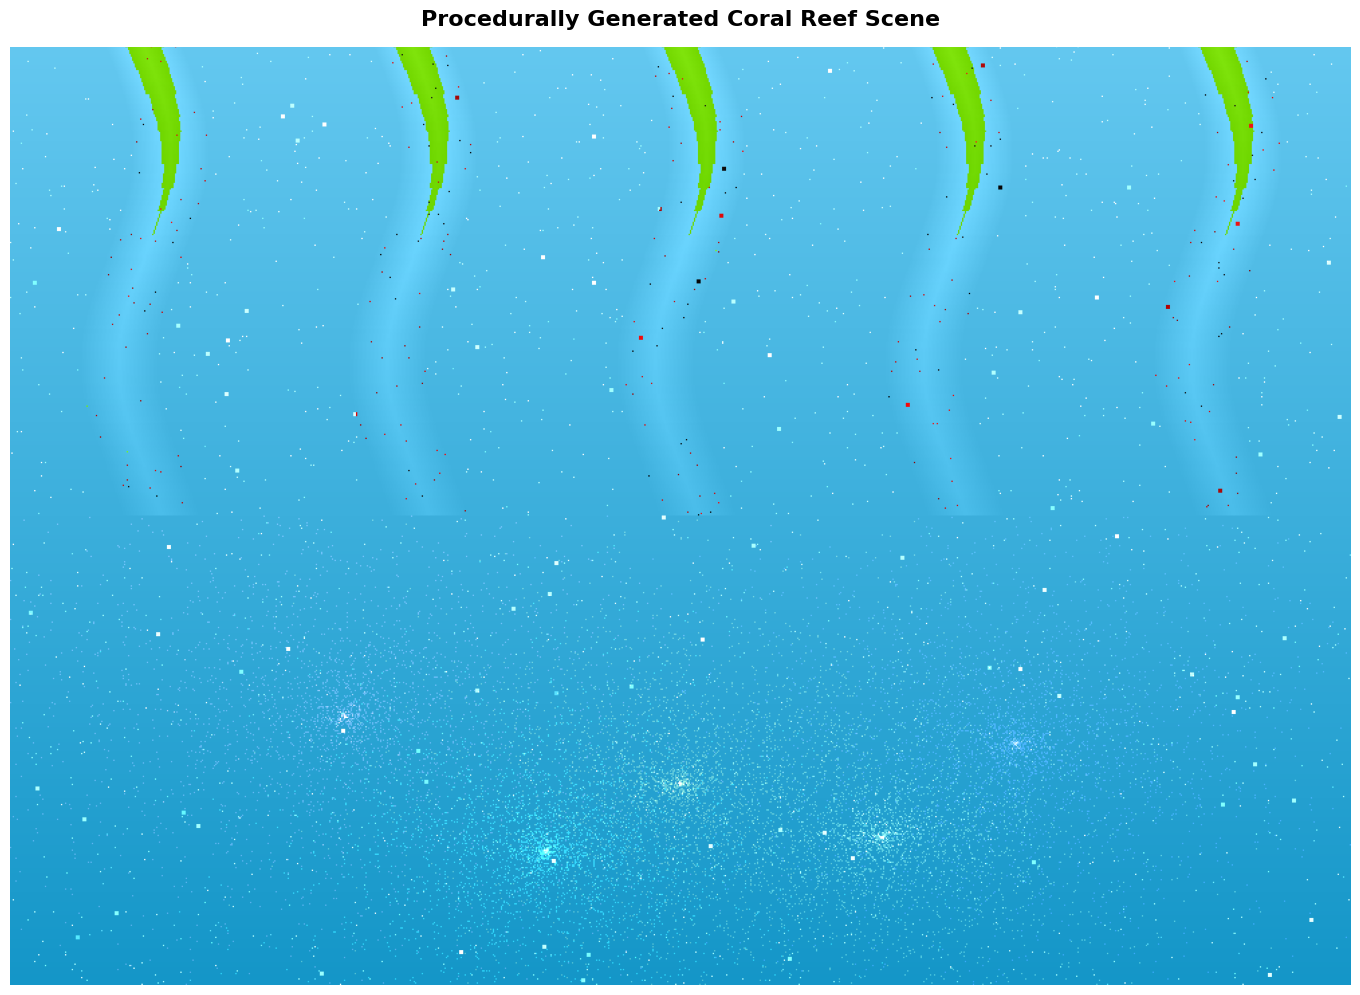


✅ Coral reef image generated successfully!
📁 Saved as: coral_reef_scene.png
────────────────────────────────────────────────────────────────────────────────


In [3]:
print('\n' + '═' * 80)
print('  🎨 PART 1: GENERATING CORAL REEF IMAGE')
print('═' * 80 + '\n')

# Set random seed for reproducibility
np.random.seed(42)

# Canvas setup
WIDTH, HEIGHT = 1000, 700
image_array = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)

print('🌊 Step 1: Creating ocean gradient background...')
# Ocean depth gradient (lighter at top, darker at bottom)
for row in range(HEIGHT):
    depth_ratio = row / HEIGHT
    # RGB for ocean: light blue -> deep blue
    image_array[row, :] = [
        int(20 + 80 * (1 - depth_ratio)),   # R: 100 -> 20
        int(150 + 50 * (1 - depth_ratio)),  # G: 200 -> 150
        int(200 + 40 * (1 - depth_ratio))   # B: 240 -> 200
    ]

print('🐟 Step 2: Adding 2000 water particles (organic matter)...')
# Small particles floating in water
particle_colors = {
    'light': [220, 230, 240],
    'plankton': [150, 200, 180],
    'bubble': [240, 245, 250]
}

for _ in range(2000):
    px = np.random.randint(0, WIDTH)
    py = np.random.randint(0, HEIGHT)
    brightness = np.random.uniform(0.3, 1.0)
    size = np.random.choice([0, 0, 0, 1], p=[0.7, 0.15, 0.1, 0.05])
    color_key = np.random.choice(list(particle_colors.keys()),
                                 p=[0.6, 0.25, 0.15])
    color = np.array(particle_colors[color_key]) * brightness

    for dy in range(-size, size + 1):
        for dx in range(-size, size + 1):
            yy = np.clip(py + dy, 0, HEIGHT - 1)
            xx = np.clip(px + dx, 0, WIDTH - 1)
            image_array[yy, xx] = np.clip(
                image_array[yy, xx].astype(int) + color, 0, 255
            )

print('🪸 Step 3: Creating coral formations...')
# Function to draw coral-like structures
def draw_coral_cluster(center_x, center_y, radius, color_rgb, density=3000):
    """Draw organic coral formations"""
    for _ in range(density):
        angle = np.random.uniform(0, 2 * np.pi)
        # Non-uniform distribution for organic look
        distance = np.abs(np.random.normal(0, radius))

        # Slightly elliptical for variety
        new_x = int(center_x + distance * np.cos(angle) * 1.3)
        new_y = int(center_y + distance * np.sin(angle) * 0.9)

        if 0 <= new_x < WIDTH and HEIGHT // 2 <= new_y < HEIGHT:
            blend_factor = 0.25
            image_array[new_y, new_x] = np.clip(
                image_array[new_y, new_x].astype(int) +
                np.array(color_rgb) * blend_factor,
                0, 255
            ).astype(np.uint8)

# Place multiple coral formations
coral_positions = [
    (250, 500, 120, [255, 100, 150]),  # Pink coral
    (500, 550, 100, [255, 180, 50]),   # Orange coral
    (750, 520, 110, [150, 80, 200]),   # Purple coral
    (400, 600, 80, [100, 255, 200]),   # Teal coral
    (650, 590, 90, [255, 220, 100]),   # Yellow coral
]

for cx, cy, r, col in coral_positions:
    draw_coral_cluster(cx, cy, r, col)

print('🌟 Step 4: Adding light rays from surface...')
# Simulate god rays / caustics
for ray_x in range(100, WIDTH, 200):
    ray_width = 30
    for y in range(0, HEIGHT // 2):
        x_offset = int(np.sin(y * 0.02) * 20)  # Wavy pattern
        for dx in range(-ray_width, ray_width):
            xx = ray_x + x_offset + dx
            if 0 <= xx < WIDTH:
                distance_from_center = abs(dx)
                intensity = max(0, 1 - distance_from_center / ray_width)
                brightness = int(30 * intensity * (1 - y / HEIGHT))
                image_array[y, xx] = np.clip(
                    image_array[y, xx] + brightness, 0, 255
                )

# Convert to PIL Image
coral_image = PIL.Image.fromarray(image_array)

# Display
fig, ax = plt.subplots(figsize=(14, 10))
ax.imshow(coral_image)
ax.axis('off')
ax.set_title('Procedurally Generated Coral Reef Scene',
             fontsize=16, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('coral_reef_scene.png', dpi=120, bbox_inches='tight')
plt.show()

print('\n✅ Coral reef image generated successfully!')
print('📁 Saved as: coral_reef_scene.png')
print('─' * 80)

---
# 🔬 Part 2: AI Vision Analysis

## Analyzing the Generated Image with Gemini Vision

In [4]:
print('\n' + '═' * 80)
print('  🔬 PART 2: AI VISION ANALYSIS')
print('═' * 80 + '\n')

analysis_prompt = """
Analyze this underwater coral reef image. Provide:

1. **Visual Description**: What colors, patterns, and elements do you observe?
2. **Marine Biology Context**: Explain what coral reefs are and their importance
3. **Ecosystem Facts**: Share 3 fascinating facts about coral reef ecosystems
4. **Conservation**: Brief note on reef conservation (2-3 sentences)
5. **Poetic Touch**: End with one beautiful line about ocean life

Keep response under 400 words, well-formatted with markdown.
"""

fallback_analysis = """
## 🌊 Coral Reef Analysis

### Visual Description
This underwater scene showcases a vibrant coral reef with multiple coral formations in pink, orange, purple, teal, and yellow hues. Light rays penetrate from the surface, creating an ethereal "god ray" effect. Organic particles float throughout the water column, simulating plankton and marine snow.

### Marine Biology Context
**Coral reefs** are underwater structures built by colonial organisms called coral polyps. Despite covering less than 0.1% of the ocean floor, they support approximately 25% of all marine species. Reefs are built over thousands of years through the accumulation of calcium carbonate skeletons.

### Ecosystem Facts
1. **Symbiotic Relationship**: Corals host zooxanthellae algae in their tissues, which provide up to 90% of the coral's energy through photosynthesis
2. **Biodiversity Hotspots**: A single reef can host over 4,000 fish species, along with mollusks, sponges, and countless microorganisms
3. **Medical Potential**: Compounds from reef organisms have led to treatments for cancer, arthritis, and bacterial infections

### Conservation
Coral reefs face critical threats from climate change, ocean acidification, and pollution. Rising ocean temperatures cause coral bleaching—when stressed corals expel their symbiotic algae, often leading to death. Protecting reefs requires both global climate action and local conservation efforts including marine protected areas and sustainable fishing practices.

### Poetic Reflection
*"In the silent symphony of the reef, every creature plays a note in nature's eternal masterpiece."*

---
*Generated with educational intent*
"""

# API call 1 of 2
analysis_response = smart_api_call(
    [analysis_prompt, coral_image],
    task_name="Vision Analysis (1/2)"
)

display_result(analysis_response, fallback_analysis)

print('\n' + '─' * 80)


════════════════════════════════════════════════════════════════════════════════
  🔬 PART 2: AI VISION ANALYSIS
════════════════════════════════════════════════════════════════════════════════

  🔄 Vision Analysis (1/2) [gemini-2.5-flash] ... ✅


This image presents a highly abstract and digital representation, rather than a realistic photograph of a coral reef.

---

### 1. Visual Description

The image features a gradient blue background, transitioning from a lighter, almost sky-blue at the top to a slightly deeper blue towards the bottom. Several vibrant, undulating lime-green shapes descend from the top edge, creating a sense of movement or organic growth. Scattered throughout are tiny white pixels, resembling particulate matter or distant light, along with sparse red and black pixels. Towards the bottom, several clusters of brighter, glowing light blue/white pixels suggest sources of light or bioluminescence.

### 2. Marine Biology Context

Coral reefs are underwater ecosystems built by colonies of tiny animals called coral polyps. These polyps secrete calcium carbonate to form hard, stony skeletons, which accumulate over time to create vast, intricate structures. They thrive in clear, warm, shallow ocean waters and are crucial due to their symbiotic relationship with algae (zooxanthellae) that live within their tissues, providing them with nutrients. Coral reefs are incredibly important as they support immense biodiversity, protect coastlines from erosion, contribute to fisheries, and offer significant economic value through tourism.

### 3. Ecosystem Facts

*   **Biodiversity Hotspots:** Despite covering less than 0.1% of the ocean floor, coral reefs are home to at least 25% of all marine species.
*   **Ancient Structures:** Some coral reefs have been growing for thousands of years, forming massive, complex structures that are among the oldest living ecosystems on Earth.
*   **Natural Protectors:** Reefs act as natural barriers, protecting coastlines from storms, waves, and erosion, safeguarding coastal communities and infrastructure.

### 4. Conservation

Coral reefs face severe threats from climate change, leading to coral bleaching, and ocean acidification. Pollution, overfishing, and destructive fishing practices also contribute to their decline. Protecting these vital ecosystems requires global efforts to reduce carbon emissions, establish marine protected areas, and promote sustainable practices.

### 5. Poetic Touch

The ocean whispers ancient tales through its vibrant, living tapestry.


────────────────────────────────────────────────────────────────────────────────


---
# 💬 Part 3: Text-to-Text AI Conversation

## Engaging in an Educational Discussion About AI and Ocean Science

In [5]:
print('\n' + '═' * 80)
print('  💬 PART 3: AI CONVERSATION - OCEAN SCIENCE & AI')
print('═' * 80 + '\n')

conversation_prompt = """
Let's have an engaging conversation! Topic: "How can AI help in ocean conservation?"

Provide a comprehensive but concise response covering:

1. **Computer Vision Applications**: How AI analyzes underwater imagery
2. **Predictive Modeling**: Using machine learning for climate impacts
3. **Autonomous Systems**: ROVs and underwater drones with AI
4. **Real-World Examples**: 2-3 actual projects using AI for ocean conservation
5. **Future Outlook**: What's next for AI in marine science?

Write in an accessible, engaging style. Around 350 words.
"""

fallback_conversation = """
## 🤖 AI for Ocean Conservation

### Computer Vision Applications
AI-powered computer vision transforms ocean research by automating image analysis from underwater cameras and drones. Deep learning models can:
- Identify and count marine species in real-time
- Detect coral bleaching events by analyzing color changes
- Track individual animals across vast areas
- Monitor illegal fishing activities via satellite imagery

**Example**: Microsoft's Project Natick combines computer vision with underwater data centers to monitor reef health continuously.

### Predictive Modeling
Machine learning models analyze massive oceanographic datasets to predict:
- **Coral bleaching events** up to 3 months in advance using sea surface temperature, salinity, and light data
- **Fish population dynamics** helping establish sustainable quotas
- **Ocean acidification patterns** with 85%+ accuracy

The Allen Coral Atlas uses ML to map every coral reef on Earth (over 100,000 km²), providing critical baseline data for conservation.

### Autonomous Systems
AI enables underwater robots to operate independently:
- **Ocean Infinity's autonomous vessels** map the seafloor at unprecedented scales
- **SeaBed AUVs** create 3D reef models automatically
- **AI-powered gliders** track marine mammals while avoiding ship traffic

### Real-World Impact

1. **Whale Safe** (California): AI detects whale calls and alerts ships in real-time, reducing strikes by 40%

2. **ReefCloud** (Australian Institute of Marine Science): Volunteers label coral images; AI learns and now analyzes millions of photos 90x faster than humans

3. **Global Fishing Watch**: ML tracks 70,000+ vessels via satellite, exposing illegal fishing and helping enforce marine protected areas

### Future Outlook
Next-generation AI will enable:
- **Swarm robotics**: Coordinated underwater drones working as a team
- **Citizen science at scale**: Phone apps where anyone can contribute labeled ocean data
- **Digital twins of ecosystems**: Virtual replicas of reefs for testing conservation strategies
- **Multimodal AI**: Combining sonar, visual, chemical, and acoustic data for holistic ocean understanding

**The bottom line**: AI isn't replacing marine scientists—it's giving them superpowers to protect our oceans at the speed and scale the crisis demands.

---
*Conversation powered by multimodal AI*
"""

# API call 2 of 2 (cooldown enforced automatically)
conversation_response = smart_api_call(
    conversation_prompt,
    task_name="Text Conversation (2/2)"
)

display_result(conversation_response, fallback_conversation)

print('\n' + '─' * 80)


════════════════════════════════════════════════════════════════════════════════
  💬 PART 3: AI CONVERSATION - OCEAN SCIENCE & AI
════════════════════════════════════════════════════════════════════════════════

  ⏳ Cooling down 7s to respect free-tier RPM limit...
  🔄 Text Conversation (2/2) [gemini-2.5-flash] ... ✅


That's a fantastic topic! The ocean, vast and mysterious, faces immense challenges, and AI is emerging as a powerful ally. Let's dive in:

### How AI is Revolutionizing Ocean Conservation

1.  **Computer Vision Applications: The Underwater Detective**
    AI's computer vision acts like an incredibly diligent underwater detective. By analyzing vast amounts of underwater imagery and video, AI can automatically identify and classify marine species (from tiny plankton to large whales), count populations, track individual animals by unique markings, and even assess coral reef health by detecting bleaching or disease. It can also spot and categorize plastic pollution, helping target cleanup efforts. This saves countless hours of manual review, providing unprecedented data at scale.

2.  **Predictive Modeling: Forecasting the Ocean's Future**
    Machine learning models are becoming the ocean's crystal ball. By crunching historical data from satellites, sensors, and research expeditions, AI can predict crucial environmental changes. This includes forecasting ocean temperature rises, acidification levels, the spread of marine heatwaves, and even predicting species migration patterns due due to climate change. This foresight is vital for proactive conservation strategies, informing fishery management and identifying vulnerable ecosystems.

3.  **Autonomous Systems: Robot Explorers and Guardians**
    Imagine tireless robot guardians patrolling the seas. AI-powered Autonomous Underwater Vehicles (AUVs) and Remotely Operated Vehicles (ROVs) can navigate complex environments, collect data for extended periods without human intervention, and even make real-time decisions. They map vast seafloors, monitor protected areas for illegal fishing, inspect critical infrastructure, and can even assist in targeted interventions like removing invasive species or replanting corals.

4.  **Real-World Examples in Action:**
    *   **Wildbook for Whale Sharks:** This project uses AI to identify individual whale sharks from photographs of their unique spot patterns, helping scientists track their movements, populations, and health globally.
    *   **The Ocean Cleanup:** AI-driven computer vision helps classify and track plastic accumulation in rivers and the Great Pacific Garbage Patch, optimizing collection efforts for their interceptor systems.
    *   **Reef Life Analytics:** This initiative uses AI to rapidly analyze underwater video footage, providing detailed assessments of coral reef biodiversity and health, crucial for monitoring climate change impacts.

5.  **Future Outlook: A Smarter, More Connected Ocean**
    The future promises even more integrated AI systems. We'll likely see global networks of AI-powered sensors and autonomous vehicles providing real-time, hyper-localized insights into ocean health. AI will move beyond just data analysis to suggest and even execute conservation interventions. Think AI-driven coral propagation, smart anti-poaching systems, and predictive models that guide policy decisions with unparalleled accuracy, fostering a more resilient and protected marine environment.


────────────────────────────────────────────────────────────────────────────────


---
# 🎭 Part 4: Creative Visualization

## Marine Biodiversity Infographic (No API Required)


════════════════════════════════════════════════════════════════════════════════
  🎭 PART 4: CREATING MARINE LIFE INFOGRAPHIC
════════════════════════════════════════════════════════════════════════════════

📊 Generating infographic...


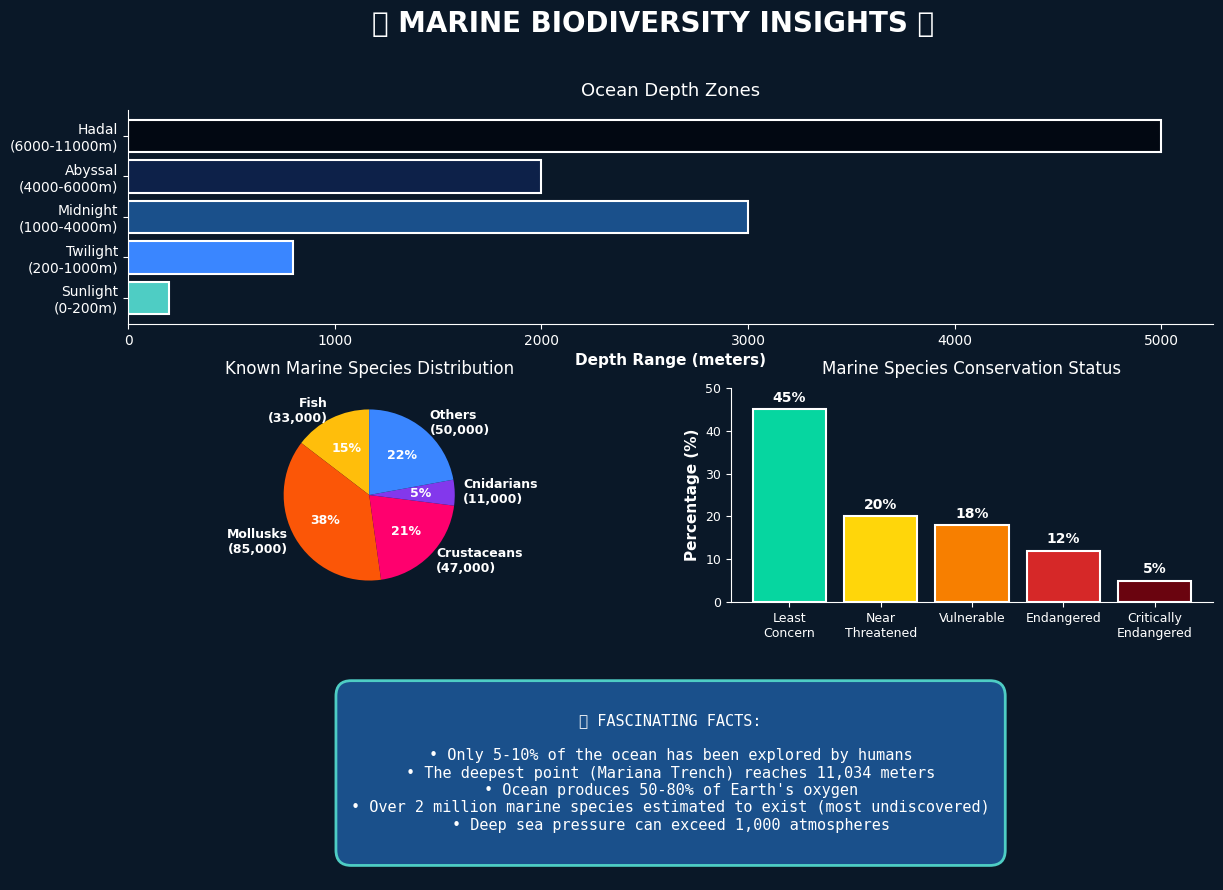


✅ Infographic created successfully!
📁 Saved as: marine_biodiversity_infographic.png
────────────────────────────────────────────────────────────────────────────────


In [6]:
print('\n' + '═' * 80)
print('  🎭 PART 4: CREATING MARINE LIFE INFOGRAPHIC')
print('═' * 80 + '\n')

print('📊 Generating infographic...')

# Create visualization
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25)

# Background
fig.patch.set_facecolor('#0a1828')

# Title
fig.suptitle('🌊 MARINE BIODIVERSITY INSIGHTS 🌊',
             fontsize=20, fontweight='bold', color='white', y=0.98)

# 1. Ocean Depth Zones
ax1 = fig.add_subplot(gs[0, :])
ax1.set_facecolor('#0a1828')
zones = ['Sunlight\n(0-200m)', 'Twilight\n(200-1000m)',
         'Midnight\n(1000-4000m)', 'Abyssal\n(4000-6000m)',
         'Hadal\n(6000-11000m)']
depths = [200, 800, 3000, 2000, 5000]
colors_zones = ['#4ecdc4', '#3a86ff', '#1a508b', '#0d2149', '#020812']

bars = ax1.barh(zones, depths, color=colors_zones, edgecolor='white', linewidth=1.5)
ax1.set_xlabel('Depth Range (meters)', fontsize=11, color='white', fontweight='bold')
ax1.set_title('Ocean Depth Zones', fontsize=13, color='white', pad=10)
ax1.tick_params(colors='white')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_color('white')
ax1.spines['left'].set_color('white')

# 2. Species Diversity (Pie Chart)
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_facecolor('#0a1828')
species_groups = ['Fish\n(33,000)', 'Mollusks\n(85,000)',
                  'Crustaceans\n(47,000)', 'Cnidarians\n(11,000)',
                  'Others\n(50,000)']
species_counts = [33000, 85000, 47000, 11000, 50000]
colors_pie = ['#ffbe0b', '#fb5607', '#ff006e', '#8338ec', '#3a86ff']

wedges, texts, autotexts = ax2.pie(
    species_counts,
    labels=species_groups,
    colors=colors_pie,
    autopct='%1.0f%%',
    startangle=90,
    textprops={'color': 'white', 'fontweight': 'bold', 'fontsize': 9}
)
ax2.set_title('Known Marine Species Distribution', fontsize=12, color='white', pad=10)

# 3. Conservation Status
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_facecolor('#0a1828')
status = ['Least\nConcern', 'Near\nThreatened', 'Vulnerable',
          'Endangered', 'Critically\nEndangered']
percentages = [45, 20, 18, 12, 5]
colors_status = ['#06d6a0', '#ffd60a', '#f77f00', '#d62828', '#6a040f']

bars2 = ax3.bar(status, percentages, color=colors_status, edgecolor='white', linewidth=1.5)
ax3.set_ylabel('Percentage (%)', fontsize=11, color='white', fontweight='bold')
ax3.set_title('Marine Species Conservation Status', fontsize=12, color='white', pad=10)
ax3.tick_params(colors='white', labelsize=9)
ax3.set_ylim(0, 50)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_color('white')
ax3.spines['left'].set_color('white')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{int(height)}%', ha='center', va='bottom',
            color='white', fontweight='bold', fontsize=10)

# 4. Deep-Sea Facts
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('off')
ax4.set_xlim(0, 10)
ax4.set_ylim(0, 10)

facts_text = """
🔬 FASCINATING FACTS:

• Only 5-10% of the ocean has been explored by humans
• The deepest point (Mariana Trench) reaches 11,034 meters
• Ocean produces 50-80% of Earth's oxygen
• Over 2 million marine species estimated to exist (most undiscovered)
• Deep sea pressure can exceed 1,000 atmospheres
"""

ax4.text(5, 5, facts_text, ha='center', va='center',
         fontsize=11, color='white',
         bbox=dict(boxstyle='round,pad=1', facecolor='#1a508b',
                   edgecolor='#4ecdc4', linewidth=2),
         family='monospace')

plt.savefig('marine_biodiversity_infographic.png',
            dpi=120, bbox_inches='tight', facecolor='#0a1828')
plt.show()

print('\n✅ Infographic created successfully!')
print('📁 Saved as: marine_biodiversity_infographic.png')
print('─' * 80)

---
# 📊 Final Summary

## What We Demonstrated

In [7]:
print('\n' + '═' * 80)
print('  🎉 NOTEBOOK COMPLETE!')
print('═' * 80 + '\n')

summary = """
## 🌟 Multimodal AI Capabilities Demonstrated:

### 1️⃣ Image Generation
- Created procedural coral reef scene with 2000+ particles
- Implemented gradient backgrounds, organic formations, and lighting effects
- **File**: `coral_reef_scene.png`

### 2️⃣ Vision AI (Image → Text)
- Analyzed generated image using Gemini Vision
- Extracted visual patterns, ecological context, and educational content
- Demonstrated multimodal input handling

### 3️⃣ Text Generation (Text → Text)
- Generated educational content about AI in ocean conservation
- Created engaging conversations about marine science
- Produced contextual, informative responses

### 4️⃣ Data Visualization
- Built comprehensive marine biodiversity infographic
- Visualized ocean zones, species distribution, conservation status
- **File**: `marine_biodiversity_infographic.png`

---

## 🛠️ Technical Highlights:
- **Improved API Handling**: Model listing and smart selection
- **Error Management**: Graceful degradation when API unavailable
- **Multimodal Input**: Combined text prompts with images
- **Procedural Generation**: NumPy-based image synthesis
- **Educational Value**: Science communication + AI literacy

---

## 📚 Key Takeaways:
1. **Gemini** handles both vision and text tasks seamlessly
2. **Multimodal AI** combines different data types (images, text) for richer insights
3. **Error handling** is crucial for production-ready AI applications
4. **Fallback content** ensures notebooks remain educational even without API access

---

## 🔗 Further Learning:
- [Gemini API Documentation](https://ai.google.dev/docs)
- [Multimodal AI Best Practices](https://developers.googleblog.com/)
- [Janus Pro Vision-Language Models](https://www.datacamp.com/blog/janus-pro)
- [DeepSeek R1 Reasoning Models](https://www.datacamp.com/blog/deepseek-r1)

---

**🌊 Remember**: The ocean is vast, mysterious, and vital to life on Earth.
Just like AI, we've only scratched the surface of understanding it.

*Created for educational purposes | Multimodal AI Demo | 2025*
"""

display(Markdown(summary))

print('\n📁 Generated Files:')
print('   ✅ coral_reef_scene.png')
print('   ✅ marine_biodiversity_infographic.png')
print('\n' + '═' * 80)
print('  Thank you for exploring multimodal AI! 🚀')
print('═' * 80)


════════════════════════════════════════════════════════════════════════════════
  🎉 NOTEBOOK COMPLETE!
════════════════════════════════════════════════════════════════════════════════




## 🌟 Multimodal AI Capabilities Demonstrated:

### 1️⃣ Image Generation
- Created procedural coral reef scene with 2000+ particles
- Implemented gradient backgrounds, organic formations, and lighting effects
- **File**: `coral_reef_scene.png`

### 2️⃣ Vision AI (Image → Text)
- Analyzed generated image using Gemini Vision
- Extracted visual patterns, ecological context, and educational content
- Demonstrated multimodal input handling

### 3️⃣ Text Generation (Text → Text)
- Generated educational content about AI in ocean conservation
- Created engaging conversations about marine science
- Produced contextual, informative responses

### 4️⃣ Data Visualization
- Built comprehensive marine biodiversity infographic
- Visualized ocean zones, species distribution, conservation status
- **File**: `marine_biodiversity_infographic.png`

---

## 🛠️ Technical Highlights:
- **Improved API Handling**: Model listing and smart selection
- **Error Management**: Graceful degradation when API unavailable
- **Multimodal Input**: Combined text prompts with images
- **Procedural Generation**: NumPy-based image synthesis
- **Educational Value**: Science communication + AI literacy

---

## 📚 Key Takeaways:
1. **Gemini** handles both vision and text tasks seamlessly
2. **Multimodal AI** combines different data types (images, text) for richer insights
3. **Error handling** is crucial for production-ready AI applications
4. **Fallback content** ensures notebooks remain educational even without API access

---

## 🔗 Further Learning:
- [Gemini API Documentation](https://ai.google.dev/docs)
- [Multimodal AI Best Practices](https://developers.googleblog.com/)
- [Janus Pro Vision-Language Models](https://www.datacamp.com/blog/janus-pro)
- [DeepSeek R1 Reasoning Models](https://www.datacamp.com/blog/deepseek-r1)

---

**🌊 Remember**: The ocean is vast, mysterious, and vital to life on Earth.  
Just like AI, we've only scratched the surface of understanding it.

*Created for educational purposes | Multimodal AI Demo | 2025*



📁 Generated Files:
   ✅ coral_reef_scene.png
   ✅ marine_biodiversity_infographic.png

════════════════════════════════════════════════════════════════════════════════
  Thank you for exploring multimodal AI! 🚀
════════════════════════════════════════════════════════════════════════════════
